In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

In [57]:
data = pd.read_csv('/content/drive/My Drive/AirBnb Project/Lin Reg/data_num_reduced.csv',index_col=['id'])

In [58]:
data

,host_listings_count,latitude,longitude,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count_private_rooms
id,,,,,,,,,,,,,,,,,,,
1947,4,41.902460,-87.63405,2,1.0,59.0,100.0,0.0,0.0,14,60,18,60,60,0,3,4,2,0
2384,1,41.787900,-87.58780,1,1.0,55.0,0.0,20.0,0.0,2,90,2,1125,1125,22,322,178,30,1
4505,1,41.854950,-87.69696,7,1.0,117.0,0.0,30.0,20.0,2,60,2,60,60,0,146,394,27,0
7126,2,41.902890,-87.68182,2,1.0,80.0,0.0,0.0,0.0,2,60,2,60,60,29,335,384,48,0
9811,10,41.917690,-87.63788,4,1.0,150.0,0.0,85.0,25.0,4,180,4,180,180,4,320,49,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43239736,1,41.799870,-87.59402,2,1.0,65.0,0.0,0.0,0.0,1,1125,1,1125,1125,14,14,0,0,0
43249502,4,41.891024,-87.67846,15,3.0,200.0,500.0,150.0,10.0,1,1125,1,1125,1125,28,178,0,0,0
43250054,1,41.976380,-87.66719,4,1.0,63.0,0.0,0.0,0.0,1,1125,1,1125,1125,24,174,0,0,1


In [59]:
to_drop = ['security_deposit','cleaning_fee','extra_people','availability_30','availability_365','maximum_minimum_nights'	,'minimum_maximum_nights','maximum_maximum_nights'	]
data = data.drop(to_drop,axis=1)

# Implementing Regression Models Trial 1 

In [60]:
X = data.drop(columns='price')
y = data.price

In [82]:
price_labels = pd.qcut(y.values, q=4,labels=['Cheap','Lower Middle','Upped Middle','Luxury'])

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression,lars_path,LassoCV,RidgeCV, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, random_state=0,test_size = 0.25)

In [64]:
linreg = LinearRegression()
linreg.fit(X_scaled,y_scaled)
print("Test score for scaled data: {:.4f}".format(linreg.score(X_scaled,y_scaled)))
coefs = pd.DataFrame(data = linreg.coef_, columns= X.columns)
display(coefs)

Test score for scaled data: 0.3693


,host_listings_count,latitude,longitude,accommodates,bathrooms,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count_private_rooms
0,0.032529,0.180254,0.209146,0.419481,0.179958,-0.021809,-0.006122,-0.073374,-0.041088,-0.122589


In [65]:
# elastic=ElasticNet(tol=.1)
# search=GridSearchCV(estimator=elastic,param_grid={'alpha':alphas,'l1_ratio':[.2,.4,.6,.8]},scoring='r2',n_jobs=1,cv=10)
# search.fit(X_train,y_train)
# search.best_score_

In [66]:
alphas = 10**np.linspace(-2,4,200)
alphas1 = np.linspace(-2,2,200)
lasso = LassoCV(alphas=alphas,cv=10).fit(X_train,y_train.ravel())
print("Score without interactions: {:.4f}".format(lasso.score(X_test, y_test)))
print('Best alpha value: {:.3f}'.format(lasso.alpha_))

Score without interactions: 0.3705
Best alpha value: 0.010


In [110]:
def lassocv(dataset,target):
  scaler = StandardScaler()
  dataset_scaled = scaler.fit_transform(dataset)
  target_transformed = scaler.fit_transform(target.values.reshape(-1,1))
  X_train, X_test, y_train, y_test = train_test_split(dataset_scaled,target_transformed, random_state=0,test_size = 0.25)
  alphas = 10**np.linspace(-2,3,200)
  lasso = LassoCV(alphas=alphas,cv=10,tol=0.1).fit(X_train, y_train.ravel()) 
  print("Score without interactions: {:.4f}".format(lasso.score(X_test, y_test)))
  print('Best alpha value: {:.3f}'.format(lasso.alpha_))
  alphas, _, coefs = lars_path(X_train, y_train.ravel(), method='lasso')
  # # plotting the LARS path
  xx = np.sum(np.abs(coefs.T), axis=1)
  xx /= xx[-1]
  plt.figure(figsize=(12,8))
  plt.plot(xx, coefs.T)
  ymin, ymax = plt.ylim()
  plt.vlines(xx, ymin, ymax, linestyle='dashed')
  plt.xlabel('|coef| / max|coef|')
  plt.ylabel('Coefficients')
  plt.title('LASSO Path')
  plt.axis('tight')
  plt.legend(X.columns,loc = 'best')
  plt.show() 

  y_pred = lasso.predict(X_test)
  labels = pd.qcut(y_pred, q=4,labels=['Cheap','Lower Middle','Upped Middle','Luxury'])
  plt.figure(figsize=(12,8))
  plt.scatter(y_test, y_pred)
  plt.plot([-5,5],[-5,5],color='blue')
  plt.grid(True)
  plt.title('Predicted vs. Actual Rental Price with LASSO CV')
  plt.ylabel('Rental Price Predicted')
  plt.xlabel('Rental Price Actual');

Score without interactions: 0.3713
Best alpha value: 0.010


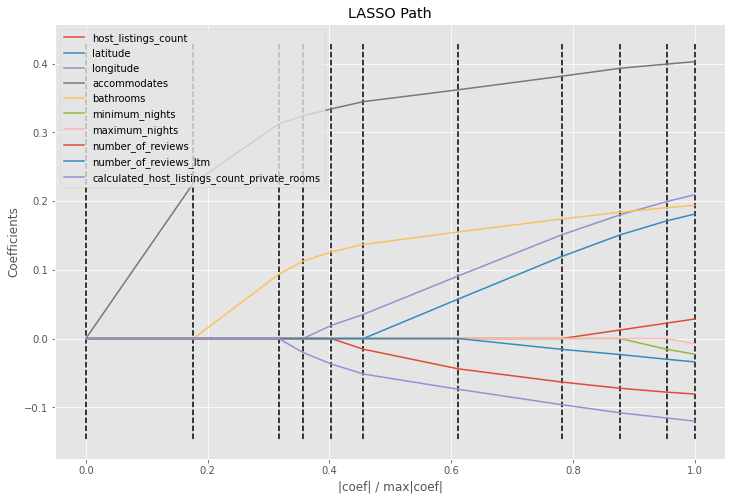

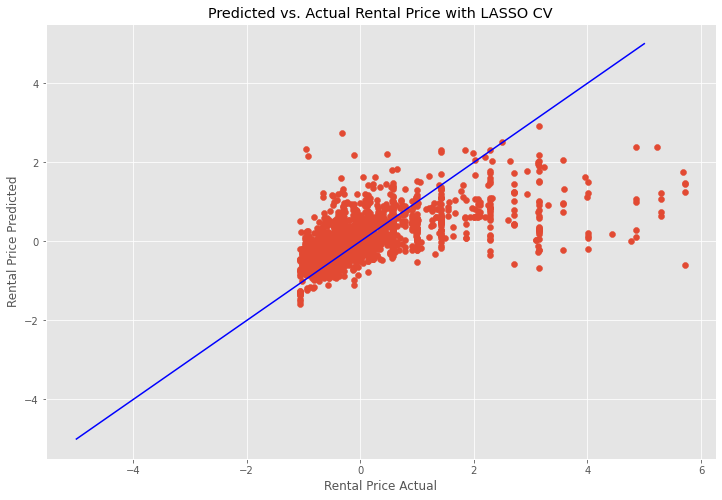

In [111]:
lassocv(X,y)

In [69]:
ridge = RidgeCV(normalize=False,alphas=alphas,cv=10).fit(X_train, y_train) 
print("R^2 Score: {:.4f}".format(ridge.score(X_test, y_test)))
print('Best alpha value: {:.3f}'.format(ridge.alpha_))

R^2 Score: 0.3715
Best alpha value: 67.475


In [70]:
from sklearn.decomposition import PCA

In [71]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print('Original Shape {}'.format(X.shape))
print('Transformed Shape {}'.format(X_pca.shape))

Original Shape (8346, 10)
Transformed Shape (8346, 2)


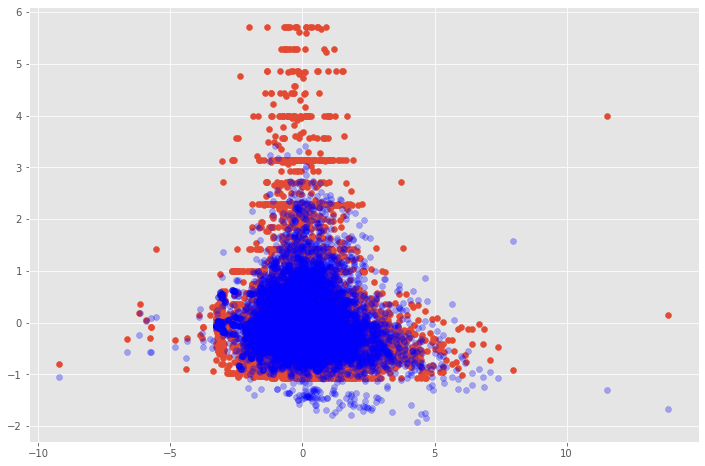

In [114]:
yfit = linreg.predict(X_scaled)
plt.figure(figsize=(12,8))
plt.scatter(X_pca[:,0],y_scaled)
plt.scatter(X_pca[:,0],yfit,c='b',alpha=0.3)

<Figure size 432x288 with 0 Axes>

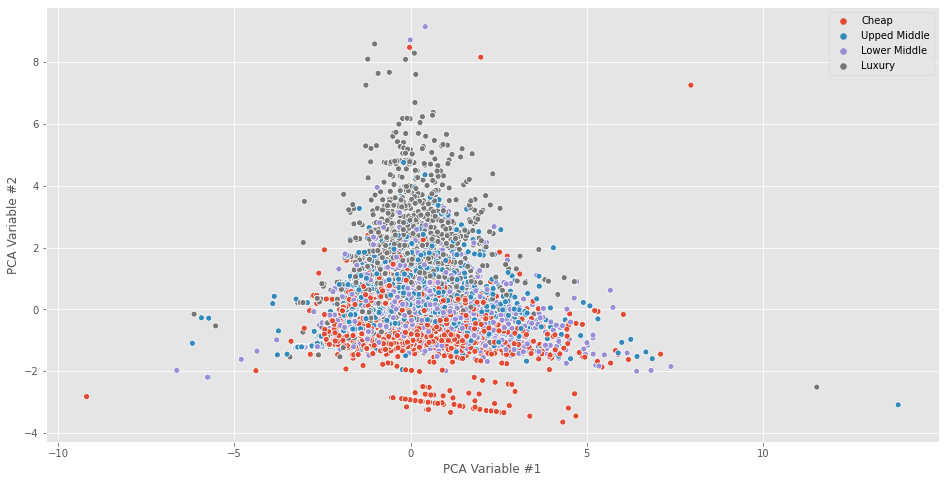

In [115]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue=price_labels)
ax.set_xlabel('PCA Variable #1')
ax.set_ylabel('PCA Variable #2')
# plt.savefig('pca 3d colored.png')
plt.show()

In [118]:
def poly_lassocv(dataset,target,z):
  scaler = StandardScaler()
  dataset_scaled = scaler.fit_transform(dataset)
  target_transformed = scaler.fit_transform(target.values.reshape(-1,1))
  X_train, X_test, y_train, y_test = train_test_split(dataset_scaled,target_transformed, random_state=0,test_size = 0.25)
  #alphas = 10**np.linspace(-2,3,200)
  poly = PolynomialFeatures(degree=z).fit(X_train)
  X_train_poly = poly.transform(X_train) 
  X_test_poly = poly.transform(X_test) 
  print("X_train.shape: {}".format(X_train.shape)) 
  print("X_train_poly.shape: {}".format(X_train_poly.shape))
  print("Polynomial feature names:\n{}".format(poly.get_feature_names()))
  # model = LinearRegression()
  # model.fit(X_train_poly, y_train)
  # print("Linear Regression Test score : {:.4f}".format(model.score(X_test_poly,y_test)))
  alphas = 10**np.linspace(-2,2,1000)
  lasso = LassoCV(alphas=alphas,cv=10,tol=0.1).fit(X_train_poly, y_train.ravel()) 
  # print("Test score for degree ", z, ":", lasso.score(X_test_poly,y_test))
  print("Test score for degree {:}: {:.3f}".format(z, lasso.score(X_test_poly,y_test)))

In [119]:
poly_lassocv(X,y,2)

X_train.shape: (6259, 10)
X_train_poly.shape: (6259, 66)
Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x7^2', 'x7 x8', 'x7 x9', 'x8^2', 'x8 x9', 'x9^2']
Test score for degree 2: 0.432
